In [2]:
%matplotlib inline
import matplotlib.pyplot as plt

# Pendule

In [8]:
from scipy.integrate import ode
from numpy import *
import numpy as np
def f(t, Y):
    theta, theta_prime=Y
    return array([theta_prime, -sin(theta)])

r = ode(f).set_integrator('vode')
r.set_initial_value(array([0,1]),0)
#print(r.integrate(0))
print(r.integrate(pi))

#dopri5

[ 0.22789468 -0.97380325]


In [9]:
def pendule(T, N=100, theta_0=0, omega_0=0):
    r = ode(f).set_integrator('vode')
    r.set_initial_value(array([theta_0,omega_0]),0)
    out = [(theta_0, omega_0)]
    for i in range(1, N):
        t = i*T/N
        out.append(r.integrate(t))
    return np.array(out)


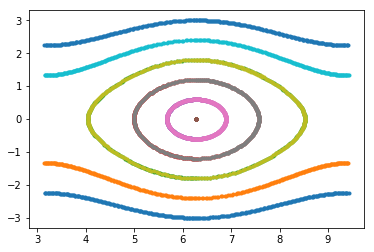

In [15]:
Tomega = linspace(-3, 3, 11)
for omega_0 in Tomega:
    out = pendule(10, N=300, omega_0=omega_0)
    plt.plot((out[:,0]-pi)%(2*pi)+pi, out[:,1], '.')

# Ions piégés

In [107]:
import numba

N = 50
m = 1
q = 1
kappa = .01
k_x = 1
k_y = 3
alpha = 0.1


x = np.random.normal(size=N)
y = np.random.normal(size=N)
vx = np.random.normal(size=N)
vy = np.random.normal(size=N)

@numba.jit
def force_totale(x, y, vx, vy, Fx, Fy):
    """ Calcule la force 
    
    x, y, vx, vy : tableaux de taille N
    
    Fx, Fy : tableaux de taille N"""
    for i in range(N):
        Fx[i] = -k_x*x[i] - alpha*vx[i]
        Fy[i] = -k_y*y[i] - alpha*vy[i]
        for j in range(N):
            if i!=j:
                d = sqrt((x[i] - x[j])**2 + (y[i] - y[j])**2)
                Fx[i] += kappa*(x[i] - x[j])/d**3
                Fy[i] += kappa*(y[i] - y[j])/d**3

def one_array_to_four_arrays(Y):
    return np.split(Y, 4)

def four_arrays_to_one_array(x, y, vx, vy):
    Y = np.concatenate([x, y, vx, vy])
    return Y

def f(t, Y):# fonction f pour ode
    Fx = np.zeros(N)
    Fy = np.zeros(N)
    x, y, vx, vy = one_array_to_four_arrays(Y)
    force_totale(x, y, vx, vy, Fx, Fy)
    return four_arrays_to_one_array(vx, vy, Fx, Fy)

In [108]:
from time import time
Y_ini = four_arrays_to_one_array(x, y, vx, vy)
r = ode(f).set_integrator('dopri5')
r.set_initial_value(Y_ini,0)

M = 200
T = 40
Tx_f = []
Ty_f = []
Tvx_f = []
Tvy_f = []
t0 = time()
for i in range(1, M):
    t_i = i*T/N
    Y_fin = r.integrate(t_i)
    x_f, y_f, vx_f, vy_f = one_array_to_four_arrays(Y_fin)
    Tx_f.append(x_f)
    Ty_f.append(y_f)
    Tvx_f.append(vx_f)
    Tvy_f.append(vy_f)    
Tx_f = np.array(Tx_f)
Ty_f = np.array(Ty_f)
Tvx_f = np.array(Tvx_f)
Tvy_f = np.array(Tvy_f)
print('Time :', time()-t0)

Time : 2.13466477394104


In [109]:
#plt.plot(Tx_f[:,0], Ty_f[:,0])
#plt.plot(Tx_f[:,1], Ty_f[:,1])

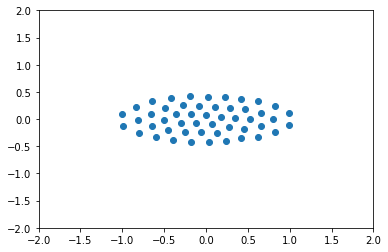

In [110]:
from matplotlib import animation, rc
from IPython.display import HTML

# First set up the figure, the axis, and the plot element we want to animate
fig, ax = plt.subplots()

ax.set_xlim(( -2, 2))
ax.set_ylim((-2, 2))

line, = ax.plot([], [], 'o')

# initialization function: plot the background of each frame
def init():
    line.set_data([], [])
    return (line,)

# animation function. This is called sequentially
def animate(i):
#    x = np.linspace(0, 2, 30)
#    y = np.sin(2 * np.pi * (x - 0.01 * i))
    line.set_data(Tx_f[i,:], Ty_f[i,:])
    return (line,)

# call the animator. blit=True means only re-draw the parts that have changed.
anim = animation.FuncAnimation(fig, animate,
                               frames=M-1, interval=20, blit=True)

HTML(anim.to_html5_video())